In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Is gpu available?', device=='cuda')
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#from transformers import pipeline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from datasets import load_dataset

Is gpu available? True


In [2]:
lab2idx = {}
idx2lab = {}
i = 0
with open('../data/emotions.txt','r') as f:
    for line in f:
        lab2idx[line.strip()]=i
        idx2lab[i] = line.strip()
        i+=1
labels = list(lab2idx.keys())

dataset = load_dataset("csv",data_files=
                       {"train": "../reformat_data/train_wide.csv",
                        "validation": "../reformat_data/val_wide.csv",
                         "test": "../reformat_data/test_wide.csv"})

Found cached dataset csv (C:/Users/lkkcp/.cache/huggingface/datasets/csv/default-af6254ecd422efea/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
print('number of labels (emotions):', len(lab2idx))
print('number of samples for training:', len(dataset['train']))
print('number of samples for validation:', len(dataset['validation']))
print('number of samples for test:', len(dataset['test']))

number of labels (emotions): 28
number of samples for training: 43410
number of samples for validation: 5426
number of samples for test: 5427


In [3]:
# Hyperparameters
model_checkpoint = "roberta-base"
MAXLEN = 256
batch_size = 4
metric_name = 'f1'
epochs = 10
weight_decay = 0.01
learning_rate = 1e-5

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def encode(samples):
    return tokenizer(samples['Text'], padding="max_length",truncation=True, max_length=MAXLEN)
def label_formatting(samples):
    labels_matrix = np.zeros((len(samples['Text']), len(labels)))
    for i, label in enumerate(labels):
        labels_matrix[:,i] = samples[label]
    return {'labels':labels_matrix.tolist()}

temp = dataset.map(encode,batched=True)
encoded_dataset = temp.map(label_formatting,batched=True,remove_columns=dataset['train'].column_names)
encoded_dataset.set_format("torch")

Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-e8fc3e634a7da0cb.arrow
Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-39e3f8a5aaf46abd.arrow


Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-71fef9d4e0c90e46.arrow
Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-f1fe0e856d04fd50.arrow


Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [7]:
def multi_label_metrics(predictions, true_labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = true_labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        true_labels=p.label_ids)
    return result

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                       problem_type="multi_label_classification", 
                                                       num_labels=len(labels),
                                                       id2label=idx2lab,
                                                       label2id=lab2idx).to(device)


args = TrainingArguments(
    f"{model_checkpoint}-goemotions",
    evaluation_strategy = "epoch",
    logging_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lkkcp\PycharmProjects\GoEmotions\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.110000,0.089094,0.556974,0.728034,0.443052
2,0.083900,0.084643,0.594151,0.755962,0.492444
3,0.074800,0.084199,0.590128,0.750928,0.480464
4,0.066800,0.087482,0.592126,0.759481,0.484888
5,0.059000,0.093285,0.580314,0.759521,0.474014
6,0.052100,0.099995,0.571645,0.759260,0.465721
7,0.046200,0.104560,0.584277,0.767639,0.480096
8,0.041100,0.108823,0.568529,0.762104,0.462956
9,0.037100,0.112492,0.574913,0.765570,0.465721
10,0.034300,0.113841,0.572087,0.764666,0.465905


TrainOutput(global_step=108530, training_loss=0.06052686072138392, metrics={'train_runtime': 31914.5863, 'train_samples_per_second': 13.602, 'train_steps_per_second': 3.401, 'total_flos': 5.71215861172224e+16, 'train_loss': 0.06052686072138392, 'epoch': 10.0})

In [9]:
trainer.evaluate()

{'eval_loss': 0.08464271575212479,
 'eval_f1': 0.594151212553495,
 'eval_roc_auc': 0.7559618462379301,
 'eval_accuracy': 0.49244378916328785,
 'eval_runtime': 83.771,
 'eval_samples_per_second': 64.772,
 'eval_steps_per_second': 16.199,
 'epoch': 10.0}

In [15]:
history_df = pd.DataFrame(trainer.state.log_history[:-2]) #The last two rows are final evaluations
history_df.head(10)
#plt.plot(history_df['eval_loss'],'-o',label='validation loss'))
#plt.plot(hi

,loss,learning_rate,epoch,step,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.1100,0.000009,1.0,10853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,10853,0.089094,0.556974,0.728034,0.443052,123.5173,43.929,10.986
2,0.0839,0.000008,2.0,21706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,21706,0.084643,0.594151,0.755962,0.492444,111.6384,48.603,12.155
4,0.0748,0.000007,3.0,32559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.0,32559,0.084199,0.590128,0.750928,0.480464,109.8212,49.408,12.356
6,0.0668,0.000006,4.0,43412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,4.0,43412,0.087482,0.592126,0.759481,0.484888,108.7354,49.901,12.480
8,0.0590,0.000005,5.0,54265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,5.0,54265,0.093285,0.580314,0.759521,0.474014,108.7162,49.910,12.482


In [24]:
history_df.tail()

,loss,learning_rate,epoch,step,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
15,NaN,NaN,8.0,86824,0.108823,0.568529,0.762104,0.462956,110.4267,49.137,12.289
16,0.0371,0.000001,9.0,97677,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,9.0,97677,0.112492,0.574913,0.765570,0.465721,110.3914,49.152,12.293
18,0.0343,0.000000,10.0,108530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,10.0,108530,0.113841,0.572087,0.764666,0.465905,111.8432,48.514,12.133


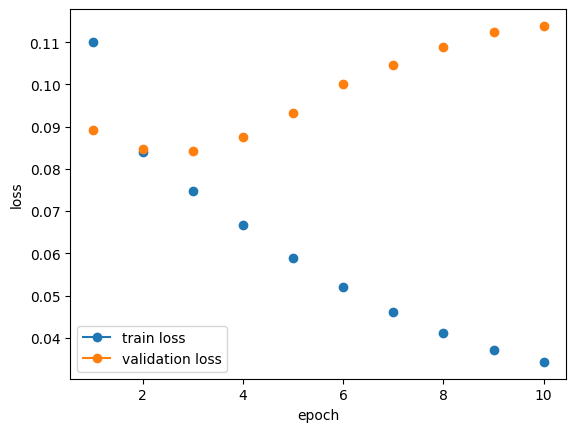

In [20]:
plt.plot(history_df['epoch'], history_df['loss'],'-o',label='train loss')
plt.plot(history_df['epoch'], history_df['eval_loss'],'-o',label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

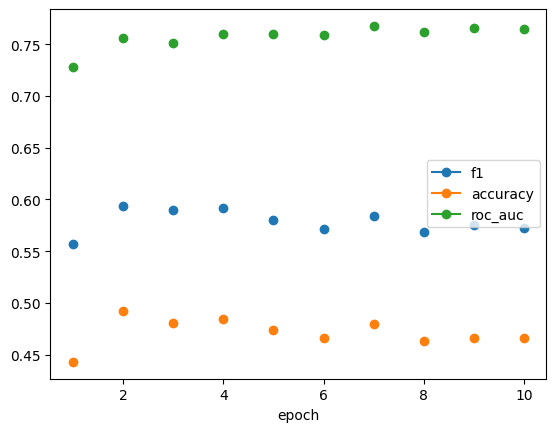

In [23]:
plt.plot(history_df['epoch'], history_df['eval_f1'],'-o',label='f1')
plt.plot(history_df['epoch'], history_df['eval_accuracy'],'-o',label='accuracy')
plt.plot(history_df['epoch'], history_df['eval_roc_auc'],'-o',label='roc_auc')
plt.legend()
plt.xlabel('epoch')
#plt.ylabel()
plt.show();

In [27]:
trainer.save_model('../../GoEmotions/DiracGiraf/roberta-base-goemotions')

In [28]:
pd.DataFrame(trainer.state.log_history).to_csv('training_log.csv')